In [1]:
import numpy as np
from sklearn.datasets import make_sparse_spd_matrix
from scipy import linalg as LA
import random
import pandas as pd
import time, os
import matplotlib.pyplot as plt

from infoband.band_info import InfoCorrBand
from wlpy.covariance import Covariance
from utils.adpt_correlation_threshold import AdptCorrThreshold
from wlpy.gist import heatmap

import warnings
warnings.filterwarnings("ignore")

In [2]:
def cov2cor(S: np.ndarray):
    # Covariance to Correlation
    D = np.diag(np.sqrt(np.diag(S)))
    D_inv = np.linalg.inv(D)
    return D_inv @ S @ D_inv

In [3]:
def gen_S_AR1(rho = 0.8, N = 500) -> np.ndarray:
    # self covariance matrix of AR(1) process
    S_block = np.zeros(shape=[N, N])
    for j in range(0, N):
        S_block = S_block + np.diag(np.ones(N-j)*(rho**j), -j) + \
        np.diag(np.ones(N-j)*(rho**j), j)
    S = S_block - np.eye(N)
    return S

In [4]:
def gen_eta_sequence(N, eta = 0.5, draw_type = 'random', is_random = False, 
                     rand_seed = 100, near_factor = 2) -> np.ndarray:
    """
    Generate a sequence b, which is a permutation of {1, ..., N}. 
    b satisfies the property: for any 0 < k < N+1, b[0]~b[k-1] include {1, ..., ceil(eta*k)}.  
    
    draw_type : {'random', 'near'}
        Algorithms about how to draw ( {b[0], ..., b[k-1]} - {1, ..., ceil(eta*k)} ). Here '-' is a subtraction between two sets.
    is_random : bool
        If False, we use random_seed as random seed, for repeat running results.
    random_seed : int
    near_factor : float
        Needed only when draw_type = 'near'.
    """
    if is_random:
        rng = random
    else:
        rng = np.random.RandomState(rand_seed)
        
    b = [1] # Default to keep the diagonal element in covariance estimation.
    b_complement = [i for i in range(2, N + 1)] # b's complement set
    
    for k in range(2, N + 1):
        # consider k-th element
        th = int(np.ceil(eta * k))
        # S^L_k include S^d_{th}
        cnt = sum([1 if num <= th else 0 for num in b])
        if cnt < th:
            for next_id in range(1, th + 1):
                if next_id not in b:
                    b.append(next_id)
                    b_complement.remove(next_id)
                    break
        else:
            # len(b_complement) == N + 1 - k
            if draw_type == 'random':
                j = rng.randint(0, N - k) if N - k > 0 else 0
            elif draw_type == 'near':
                upper = min(int(near_factor * k), N - k)
                j = rng.randint(0, upper) if upper > 0 else 0
            else:
                raise Exception('draw_type, value error')
            next_id = b_complement[j] 
            b.append(next_id)
            b_complement.remove(next_id)
    return np.array(b)

In [5]:
def gen_L(S, eta, verbose = False, draw_type = 'random', is_random = False, 
          rand_seed = 100, near_factor = 2):
    N = S.shape[0]
    new_rowSort = np.zeros((N, N))
    
    R = cov2cor(S)
    L = abs(R)
    rowSort = InfoCorrBand(X = np.eye(N), L = L).rowSort # You can ignore the 'X = np.eye(N)' parameter. I create this temporary object solely to get 'rowSort' matrix.
    
    for i in range(N):
        row = rowSort[i]
        argst = row.argsort()
        b = gen_eta_sequence(N, eta, draw_type, is_random, rand_seed, near_factor)
        for j in range(N):
            new_rowSort[i][argst[j]] = b[j]
    
    L_eta = 1 / new_rowSort
    res = (L_eta, new_rowSort, rowSort)
    return res if verbose else L_eta

In [6]:
def get_title_1(ord, cov_cor, draw_type, eta, N, T, rho, near_factor = None):
    title = "{ord}, {cov_cor} error, {draw_type}, eta=({eta}, {near_factor}), (N, T)=({N}, {T}), rho={rho}".format(
        ord = ord, cov_cor = cov_cor, draw_type = draw_type, eta = eta, N = N, T = T, rho = rho, near_factor = near_factor)
    return title

In [7]:
def save_data_fig(x, ord, cov_cor, draw_type, eta, N, T, rho, near_factor = None, 
                  is_save = False):
    x = list(x)
    
    title = get_title_1(ord, cov_cor, draw_type, eta, N, T, rho, near_factor)
    data_path = 'data/' + title + '.txt'
    fig_path = 'data/' + title + '.png'
    print(data_path)
    
    old_x = np.loadtxt(fname = data_path, ndmin = 1).tolist() if os.path.exists(data_path) else []
    full_x = x + old_x
    size = len(full_x)
    
    plt.figure(figsize = (10, 1))
    plt.hist(x = full_x, bins = 100, color = '#0504aa', alpha = 0.7, rwidth = 0.85)
    plt.title(title + ", size={}".format(size))
    plt.xlabel("error rate")
    plt.ylabel("frequency")
    
    if is_save:
        plt.savefig(fig_path, bbox_inches = 'tight')
        np.savetxt(fname = data_path, X = full_x)

In [10]:
N = 100
T = 50
rho = 0.8
S = gen_S_AR1(N = N, rho = rho)
R = cov2cor(S)

seed = 1
rng = np.random.RandomState(seed) if 1 else np.random
X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)

fro 0.5 near 0.5
0 14
1 15
2 17
3 13
4 20
5 14
6 11
7 3


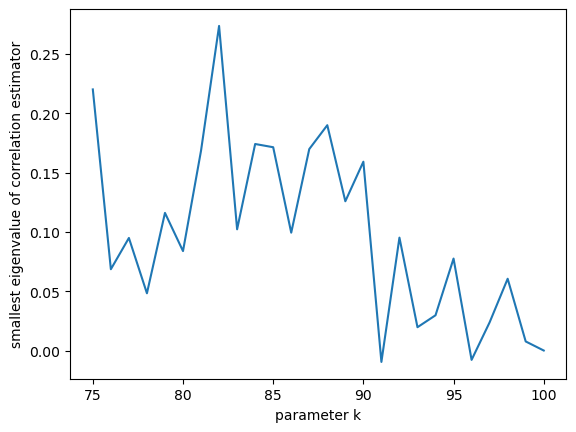

8 14
9 14
10 18
11 16
12 4
13 16
14 15
15 12
16 21
17 3


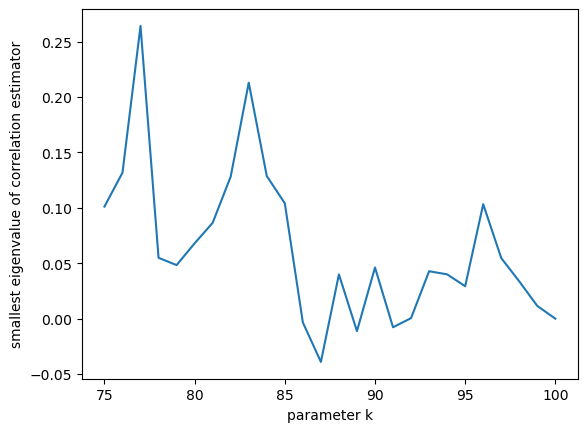

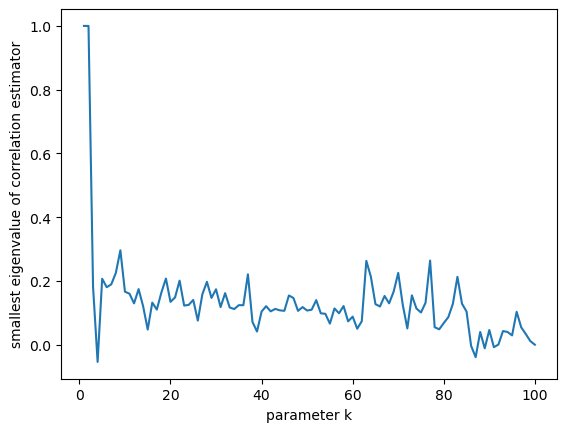

In [30]:
for ord in ['fro', 2]:
    for eta in [0.5, 0.8, 1]:
        for draw_type, near_factor in [('near', 0.5), ('near', 1), ('near', 2), ('random', None)]:
            err_cor = []
            err_cov = []
            
            print(ord, eta, draw_type, near_factor)
            
            for i in range(100):
                L = gen_L(S, eta, draw_type = draw_type, is_random = 1, near_factor = near_factor)
                c = InfoCorrBand(X, L)
                R_est, S_est, k = c.auto_fit()
                
                print(i, k)
                if k <= 3:
                    k = c.k_by_cv()
                
                err_cor.append(LA.norm(R - R_est, ord))
                err_cov.append(LA.norm(S - S_est, ord))
            err_cor = err_cor / LA.norm(R, ord)
            err_cov = err_cov / LA.norm(S, ord)
            
            save_data_fig(err_cor, ord, 'cor', draw_type, eta, N, T, rho, near_factor, is_save = 1)
            save_data_fig(err_cov, ord, 'cov', draw_type, eta, N, T, rho, near_factor, is_save = 1)
    

In [27]:
L = gen_L(S, 0.5, draw_type = 'random', is_random = 1, near_factor = 0.5)
c = InfoCorrBand(X, L)
c.k_by_cv()

16

In [12]:
c = InfoCorrBand(X, abs(R))
R_est, S_est, k = c.auto_fit()
m = Covariance(X)

In [13]:
def show_rs(S: np.ndarray, 
            m: Covariance, 
            ord = 'fro'):
    # ord: norm type
    R = cov2cor(S)
    print(ord)
    print('----------'*2)
    print('Correlation itself', LA.norm(R, ord))
    print('Error:')
    print('Sample', LA.norm(cov2cor(m.sample_cov()) - R, ord))
    print('Linear Shrinkage', LA.norm(cov2cor(m.lw_lin_shrink()) - R, ord))
    print('Nonlinear Shrinkage', LA.norm(cov2cor(m.nonlin_shrink()) - R, ord))
    print()
    print('Covariance itself', LA.norm(S, ord))
    print('Error:')
    print('Sample', LA.norm(m.sample_cov() - S, ord))
    print('Linear Shrinkage', LA.norm(m.lw_lin_shrink() - S, ord))
    print('Nonlinear Shrinkage', LA.norm(m.nonlin_shrink() - S, ord))
    print('----------'*2)
    return

In [57]:
# show_rs(S, m, 'fro')
# show_rs(S, m, 2)
# show_rs(S, m, 1)

# ----------------------------
plot the distribution of error rates

In [ ]:
# res1 = []
# res2 = []

In [71]:
for i in range(200):
    L1 = gen_L(S, eta = 0.5, verbose = 0, 
            draw_type = 'near', is_random = 1)
    c1 = InfoCorrBand(X = X, L = L1, num_cv = 20)
    # R_est1, S_est1, k1 = c1.auto_fit()
    res = c1.auto_fit()
    res1.append(res)
    # print(res[2])

20
18
18
6
17
15
19
19
6
10
6
7
7
16
22
24
19
17
4
7
16
20
3
17
21
25
6
7
8
22
5
23
16
21
21
14
4


KeyboardInterrupt: 

# --------------------

In [29]:
for ord in ['fro', 2, 1]:
    print(ord, 'cor')
    print(LA.norm(R - R_est, ord))
    print(LA.norm(R - R_est1, ord))
    print(LA.norm(R - R_est2, ord))
    print(ord, 'cov')
    print(LA.norm(S - S_est, ord))
    print(LA.norm(S - S_est1, ord))
    print(LA.norm(S - S_est2, ord))

fro cor
5.3547379898153045
6.452088354585957
12.623341873998882
fro cov
8.20827979110684
8.9617152976866
13.40982410842072
2 cor
1.7832402677573187
1.769745999552205
4.998685228078624
2 cov
4.977860270444561
4.96973660159217
5.091390155453619
1 cor
3.9752892005894385
4.283611905894455
6.733673932336882
1 cov
8.690140091661135
8.734167335328328
8.482216067368222


In [15]:
df = pd.DataFrame({'a':[[2,3],2,3]})
df

,a
0,"[2, 3]"
1,2
2,3


In [61]:
# heatmap(R)
# heatmap(R_est)
# heatmap(R_est1)
# heatmap(R_est2)
# heatmap(c.sample_corr())

In [21]:
c.auto_fit()

(array([[1.        , 0.75607612, 0.57857393, ..., 0.        , 0.        ,
         0.        ],
        [0.75607612, 1.        , 0.81429886, ..., 0.        , 0.        ,
         0.        ],
        [0.57857393, 0.81429886, 1.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 1.        , 0.81889317,
         0.66621149],
        [0.        , 0.        , 0.        , ..., 0.81889317, 1.        ,
         0.84207442],
        [0.        , 0.        , 0.        , ..., 0.66621149, 0.84207442,
         1.        ]]),
 array([[1.06586502, 0.75682257, 0.58198612, ..., 0.        , 0.        ,
         0.        ],
        [0.75682257, 0.94005854, 0.76924368, ..., 0.        , 0.        ,
         0.        ],
        [0.58198612, 0.76924368, 0.94930403, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.98563935, 0.82672521,
         0.81246694],
        [0. 

In [63]:
class time_printer():
    def __init__(self):
        self.t = time.time()
        self.t_next = None
        
    def tick(self):
        self.t_next = time.time()
        print("    Time Interval: {}".format(self.t_next - self.t))
        self.t = self.t_next

In [64]:
is_random = False
rng = (random if is_random else np.random.RandomState(100)) # 300_300:101. other: 100
N = 400
T = 300
res = []
rho_range = [0.8, 0.9, 0.95, 0.99]
eta_range = [0.5, 0.8, 1]
ord_range = ['fro', 2]
near_factor_range = [0.5, 1, 2]
tp = time_printer()

In [24]:
print(N, T)
for rho in rho_range:
    print("rho: ", rho)
    
    S = gen_S_AR1(rho = rho, N = N)
    R = cov2cor(S)
    X = rng.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
    
    m = Covariance(X)
    S_l = m.lw_lin_shrink()
    R_l = cov2cor(S_l)
    S_nl = m.nonlin_shrink()
    R_nl = cov2cor(S_nl)
    
    tp.tick()
    
    for eta in eta_range:
        for near_factor in near_factor_range:
            print("eta, near_factor: ", eta, near_factor)
            
            L = gen_L(S, eta, 
                draw_type = 'near', 
                is_random = is_random, 
                near_factor = near_factor)   
            
            tp.tick()
                
            c = InfoCorrBand(X, L)
            
            tp.tick()
            
            R_est, S_est = c.auto_fit()[:2]
            
            tp.tick()
            
            for ord in ord_range:   
                print("ord: ", ord)
                
                dct_cov = {'group': 'S', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(S, ord), 
                    'Sample': LA.norm(c.sample_cov() - S, ord), 
                    'Linear Shrinkage': LA.norm(S_l - S, ord), 
                    'Nonlinear Shrinkage': LA.norm(S_nl - S, ord), 
                    'Info Band': LA.norm(S_est - S, ord)}
                dct_cor = {'group': 'R', 
                    'norm type': ord, 
                    'rho': rho, 
                    'eta': eta, 
                    'near factor': near_factor, 
                    'S or R': LA.norm(R, ord), 
                    'Sample': LA.norm(c.sample_corr() - R, ord), 
                    'Linear Shrinkage': LA.norm(R_l - R, ord), 
                    'Nonlinear Shrinkage': LA.norm(R_nl - R, ord), 
                    'Info Band': LA.norm(R_est - R, ord)}
                res += [dct_cov, dct_cor]
                
                tp.tick()

400 300
rho:  0.8
    Time Interval: 0.9151647090911865
eta, near_factor:  0.5 0.5
    Time Interval: 4.885119199752808
    Time Interval: 0.07583808898925781


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(res)
df

In [ ]:
path = 'resultData/'
file_name = 'result_' + str(N) + '-' + str(T) + '.csv'
df.to_csv(path + file_name)
# df.to_csv(path + file_name, float_format = '%.5f') 

dataframe 追加模式 https://blog.csdn.net/lost0910/article/details/105321888

# test

In [ ]:
N = 400
T = 400
S = gen_S_AR1(rho = 0.9, N = N)
R = cov2cor(S)
X = np.random.multivariate_normal(mean = np.zeros(N), cov = S, size = T)
m = Covariance(X)
S_nl = m.nonlin_shrink()
print(S_nl)
lam, u = np.linalg.eigh(m.sample_cov())
print(lam)